In [1]:
import torch
import numpy as np
import random
import torch.nn as nn
import torch.nn.functional as F
import itertools
import pdb
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import os
import sys

sys.path.insert(0, './src')

from data import Dataset
from kernels import HMC_our, HMC_vanilla, Reverse_kernel, Accept_func
from models import Gen_network, Inf_network, Inf_network_simple, Gen_network_simple
from target import NN_bernoulli, GMM_target, NN_Gaussian
from utils import plot_digit_samples, get_samples
from args import get_args

In [4]:
class My_net(nn.Module):
    def __init__(self,):
        super(My_net, self).__init__()
        self.device_zero = nn.Parameter(torch.tensor(0., dtype=torch.float32), requires_grad=False)
        self.device_one = nn.Parameter(torch.tensor(1., dtype=torch.float32), requires_grad=False)
        self.uniform = torch.distributions.Uniform(low=self.device_zero,
                                                   high=self.device_one)  # distribution for transition making
    def forward(self):
        print(self.device_zero)
        print(self.device_one) 
        print(self.uniform.sample((10,)))

In [5]:
net = My_net().to('cuda:1')

In [7]:
[p for p in net.parameters()]

[Parameter containing:
 tensor(0., device='cuda:1'),
 Parameter containing:
 tensor(1., device='cuda:1')]

In [2]:
torchType = torch.float32

In [3]:
def set_seeds(rand_seed):
    torch.cuda.manual_seed_all(rand_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(rand_seed)
    np.random.seed(rand_seed)
    random.seed(rand_seed)

seed = 1 # 1337 #
set_seeds(seed)

In [4]:
args = get_args()

args.data = "mnist"
args.z_dim = 64
args.data_distrib = GMM_target(args, args.device)

In [5]:
if args.data == 'toy_data':
    encoder = Inf_network_simple(kwargs=args).to(args.device)
    target = NN_Gaussian(kwargs=args, model=Gen_network_simple(args.z_dim, args), device=args.device).to(args.device)   
else:
    encoder = Inf_network(kwargs=args).to(args.device)
    target = NN_bernoulli(kwargs=args, model=Gen_network(args.z_dim, args), device=args.device).to(args.device)

if args.learnable_reverse:
    reverse_kernel = Reverse_kernel(kwargs=args).to(args.device)
    reverse_params = reverse_kernel.parameters()
else:
    reverse_params = list([])

if args.learnable_accept:
    accept_func = Accept_func(kwargs=args).to(args.device)
    accept_params = accept_func.parameters()
else:
    accept_params = list([])
    accept_func = None
    
if args.amortize:
    transitions = HMC_our(kwargs=args).to(args.device)
else:
    transitions = nn.ModuleList([HMC_our(kwargs=args).to(args.device) for _ in range(args['K'])])
    
if args.fix_transition_params:
    for p in transitions.parameters():
        transitions.requires_grad_(False)

if args.separate_params:
    params_decoder = list(target.parameters())
    params_inference = list(encoder.parameters()) + list(transitions.parameters()) + list(reverse_params) +list(accept_params)
    optimizer_inference = torch.optim.Adam(params=params_inference, lr=args.learning_rate_inference)
    optimizer = torch.optim.Adam(params=params_decoder, lr=args.learning_rate)
else:
    params = list(encoder.parameters()) + list(target.parameters()) + list(transitions.parameters()) + list(reverse_params)+list(accept_params)
    optimizer = torch.optim.Adam(params=params, lr=args.learning_rate)
    
optimizer_vanilla = torch.optim.Adam(params=list(encoder.parameters()) + list(target.parameters()), lr= args.learning_rate_vanilla)



In [6]:
if args.vanilla_vae_epoches > 0:
    batch_size = args.train_batch_size
    args.train_batch_size = 100 # just for Vanilla VAE training
dataset = Dataset(args, device=args.device)

In [7]:
random_code = args.std_normal.sample((64, args.z_dim))

In [8]:
def compute_loss(z_new, p_new, u, p_old, x, sum_log_alpha, sum_log_jac, sum_log_sigma, mu=None, all_directions=None, h=None):
    if args.learnable_reverse:
        log_r = reverse_kernel(z_fin=z_new.detach(), h=h.detach(), a=all_directions)
        log_m = args.std_normal.log_prob(u).sum(1) + args.std_normal.log_prob(p_old).sum(1) - sum_log_jac - sum_log_sigma + sum_log_alpha
    else:
        log_r = 0 #-args.K * torch_log_2
        log_m = args.std_normal.log_prob(u).sum(1) + args.std_normal.log_prob(p_old).sum(1) - sum_log_jac - sum_log_sigma # + sum_log_alpha
        
    log_p = target.get_logdensity(z=z_new, x=x) + args.std_normal.log_prob(p_new.sum(1))
    elbo_full = log_p + log_r - log_m
    grad_elbo = torch.mean(elbo_full + elbo_full.detach() * sum_log_alpha)
    return elbo_full, grad_elbo 

In [9]:
def validate_vae(args, encoder, target, transitions, dataset):
    elbo_list = []
    for batch_num, batch_val in enumerate(dataset.next_val_batch()):
        if args.learnable_reverse:
            all_directions = torch.tensor([], device=args.device)
        else:
            all_directions = None
        mu, sigma, h = encoder(batch_val)
        
        sum_log_alpha = torch.zeros(mu.shape[0], dtype=args.torchType, device=args.device) # for grad log alpha accumulation
        sum_log_jacobian = torch.zeros(mu.shape[0], dtype=args.torchType, device=args.device) # for log_jacobian accumulation
        sum_log_sigma = torch.sum(torch.log(sigma), 1)

        u = args.std_normal.sample(mu.shape)
        z = mu + sigma * u
        
        p_old = args.std_normal.sample(z.shape)
        cond_vectors = [args.std_normal.sample(p_old.shape) for k in range(args.K)]
        p = p_old
        
        for k in range(args.K):
            if args.amortize:
                z, p, log_jac, current_log_alphas, directions, _ = transitions.make_transition(q_old=z, x=batch_val,
                                                    p_old=p, k=cond_vectors[k], target_distr=target, accept_func= accept_func, h=h)
            else:
                z, p, log_jac, current_log_alphas, directions, _ = transitions[k].make_transition(q_old=z, x=batch_val,
                                                                    p_old=p, k=cond_vectors[k], target_distr=target, accept_func= accept_func, h=h) # sample a_i -- directions
            if args.learnable_reverse:
                all_directions = torch.cat([all_directions, directions.view(-1, 1)], dim=1)
            sum_log_alpha = sum_log_alpha + current_log_alphas
            sum_log_jacobian = sum_log_jacobian + log_jac  # refresh log jacobian
        
        elbo_current, _ = compute_loss(z_new=z, p_new=p, u=u, p_old=p_old, x=batch_val, sum_log_alpha=sum_log_alpha,
                                    sum_log_jac=sum_log_jacobian, sum_log_sigma=sum_log_sigma, mu=mu, all_directions=all_directions, h=h)
        
        elbo_list.append(elbo_current.cpu().detach().numpy())
    mean_val_elbo = np.mean(elbo_list)
    return mean_val_elbo

  0%|          | 0/1000 [00:00<?, ?it/s]

On batch number 1/590 and on k = 1 we have for  0: 0.6399999856948853 and for +1: 0.35999999195337296
On batch number 1/590 and on k = 2 we have for  0: 0.6999999843537807 and for +1: 0.29999999329447746
On batch number 101/590 and on k = 1 we have for  0: 0.5799999870359898 and for +1: 0.41999999061226845
On batch number 101/590 and on k = 2 we have for  0: 0.6299999859184027 and for +1: 0.36999999172985554
On batch number 201/590 and on k = 1 we have for  0: 0.5899999868124723 and for +1: 0.40999999083578587
On batch number 201/590 and on k = 2 we have for  0: 0.6399999856948853 and for +1: 0.35999999195337296
On batch number 301/590 and on k = 1 we have for  0: 0.6199999861419201 and for +1: 0.3799999915063381
On batch number 301/590 and on k = 2 we have for  0: 0.6599999852478504 and for +1: 0.3399999924004078
On batch number 401/590 and on k = 1 we have for  0: 0.6499999854713678 and for +1: 0.3499999921768904
On batch number 401/590 and on k = 2 we have for  0: 0.669999985024333 

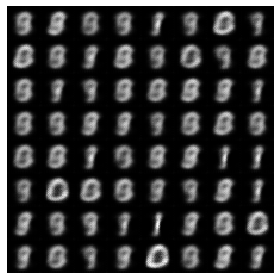

  0%|          | 1/1000 [00:48<13:23:50, 48.28s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.6199999861419201 and for +1: 0.3799999915063381
On batch number 1/590 and on k = 2 we have for  0: 0.6999999843537807 and for +1: 0.29999999329447746
On batch number 101/590 and on k = 1 we have for  0: 0.7199999839067459 and for +1: 0.2799999937415123
On batch number 101/590 and on k = 2 we have for  0: 0.7099999841302633 and for +1: 0.2899999935179949
On batch number 201/590 and on k = 1 we have for  0: 0.6799999848008156 and for +1: 0.3199999928474426
On batch number 201/590 and on k = 2 we have for  0: 0.7099999841302633 and for +1: 0.2899999935179949
On batch number 301/590 and on k = 1 we have for  0: 0.6499999854713678 and for +1: 0.3499999921768904
On batch number 301/590 and on k = 2 we have for  0: 0.7399999834597111 and for +1: 0.25999999418854713
On batch number 401/590 and on k = 1 we have for  0: 0.7099999841302633 and for +1: 0.2899999935179949
On batch number 401/590 and on k = 2 we have for  0: 0.6499999854713678 and

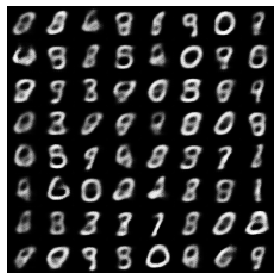

  0%|          | 2/1000 [01:36<13:23:59, 48.34s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.7399999834597111 and for +1: 0.25999999418854713
On batch number 1/590 and on k = 2 we have for  0: 0.7599999830126762 and for +1: 0.23999999463558197
On batch number 101/590 and on k = 1 we have for  0: 0.7599999830126762 and for +1: 0.23999999463558197
On batch number 101/590 and on k = 2 we have for  0: 0.8699999805539846 and for +1: 0.12999999709427357
On batch number 201/590 and on k = 1 we have for  0: 0.7099999841302633 and for +1: 0.2899999935179949
On batch number 201/590 and on k = 2 we have for  0: 0.8199999816715717 and for +1: 0.17999999597668648
On batch number 301/590 and on k = 1 we have for  0: 0.8399999812245369 and for +1: 0.1599999964237213
On batch number 301/590 and on k = 2 we have for  0: 0.7499999832361937 and for +1: 0.24999999441206455
On batch number 401/590 and on k = 1 we have for  0: 0.7499999832361937 and for +1: 0.24999999441206455
On batch number 401/590 and on k = 2 we have for  0: 0.809999981895089

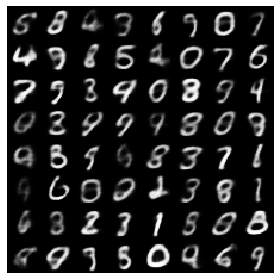

  0%|          | 3/1000 [02:25<13:23:50, 48.38s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.7499999832361937 and for +1: 0.24999999441206455
On batch number 1/590 and on k = 2 we have for  0: 0.7999999821186066 and for +1: 0.19999999552965164
On batch number 101/590 and on k = 1 we have for  0: 0.7499999832361937 and for +1: 0.24999999441206455
On batch number 101/590 and on k = 2 we have for  0: 0.8899999801069498 and for +1: 0.1099999975413084
On batch number 201/590 and on k = 1 we have for  0: 0.8099999818950891 and for +1: 0.18999999575316906
On batch number 201/590 and on k = 2 we have for  0: 0.8099999818950891 and for +1: 0.18999999575316906
On batch number 301/590 and on k = 1 we have for  0: 0.789999982342124 and for +1: 0.20999999530613422
On batch number 301/590 and on k = 2 we have for  0: 0.8599999807775021 and for +1: 0.13999999687075615
On batch number 401/590 and on k = 1 we have for  0: 0.7499999832361937 and for +1: 0.24999999441206455
On batch number 401/590 and on k = 2 we have for  0: 0.739999983459711

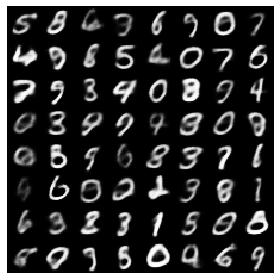

  0%|          | 4/1000 [03:13<13:23:09, 48.38s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.7699999827891588 and for +1: 0.2299999948590994
On batch number 1/590 and on k = 2 we have for  0: 0.8599999807775021 and for +1: 0.13999999687075615
On batch number 101/590 and on k = 1 we have for  0: 0.7599999830126762 and for +1: 0.23999999463558197
On batch number 101/590 and on k = 2 we have for  0: 0.7499999832361937 and for +1: 0.24999999441206455
On batch number 201/590 and on k = 1 we have for  0: 0.7399999834597111 and for +1: 0.25999999418854713
On batch number 201/590 and on k = 2 we have for  0: 0.789999982342124 and for +1: 0.20999999530613422
On batch number 301/590 and on k = 1 we have for  0: 0.8299999814480543 and for +1: 0.1699999962002039
On batch number 301/590 and on k = 2 we have for  0: 0.8999999798834324 and for +1: 0.09999999776482582
On batch number 401/590 and on k = 1 we have for  0: 0.7799999825656414 and for +1: 0.2199999950826168
On batch number 401/590 and on k = 2 we have for  0: 0.789999982342124 a

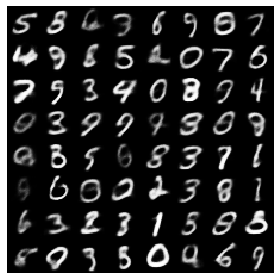

  0%|          | 5/1000 [04:02<13:22:30, 48.39s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.7999999821186066 and for +1: 0.19999999552965164
On batch number 1/590 and on k = 2 we have for  0: 0.7999999821186066 and for +1: 0.19999999552965164
On batch number 101/590 and on k = 1 we have for  0: 0.6899999845772982 and for +1: 0.30999999307096004
On batch number 101/590 and on k = 2 we have for  0: 0.8399999812245369 and for +1: 0.1599999964237213
On batch number 201/590 and on k = 1 we have for  0: 0.6899999845772982 and for +1: 0.30999999307096004
On batch number 201/590 and on k = 2 we have for  0: 0.8499999810010195 and for +1: 0.14999999664723873
On batch number 301/590 and on k = 1 we have for  0: 0.6599999852478504 and for +1: 0.3399999924004078
On batch number 301/590 and on k = 2 we have for  0: 0.7699999827891588 and for +1: 0.2299999948590994
On batch number 401/590 and on k = 1 we have for  0: 0.669999985024333 and for +1: 0.3299999926239252
On batch number 401/590 and on k = 2 we have for  0: 0.8399999812245369 a

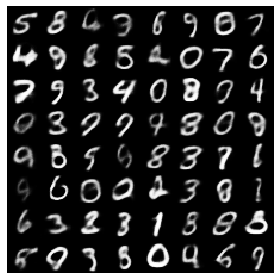

  1%|          | 6/1000 [04:50<13:21:51, 48.40s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.7399999834597111 and for +1: 0.25999999418854713
On batch number 1/590 and on k = 2 we have for  0: 0.7299999836832285 and for +1: 0.2699999939650297
On batch number 101/590 and on k = 1 we have for  0: 0.7599999830126762 and for +1: 0.23999999463558197
On batch number 101/590 and on k = 2 we have for  0: 0.789999982342124 and for +1: 0.20999999530613422
On batch number 201/590 and on k = 1 we have for  0: 0.7199999839067459 and for +1: 0.2799999937415123
On batch number 201/590 and on k = 2 we have for  0: 0.8099999818950891 and for +1: 0.18999999575316906
On batch number 301/590 and on k = 1 we have for  0: 0.6999999843537807 and for +1: 0.29999999329447746
On batch number 301/590 and on k = 2 we have for  0: 0.789999982342124 and for +1: 0.20999999530613422
On batch number 401/590 and on k = 1 we have for  0: 0.789999982342124 and for +1: 0.20999999530613422
On batch number 401/590 and on k = 2 we have for  0: 0.789999982342124 an

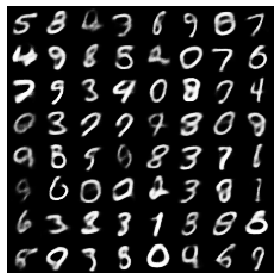

  1%|          | 7/1000 [05:38<13:21:17, 48.42s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.789999982342124 and for +1: 0.20999999530613422
On batch number 1/590 and on k = 2 we have for  0: 0.8399999812245369 and for +1: 0.1599999964237213
On batch number 101/590 and on k = 1 we have for  0: 0.7399999834597111 and for +1: 0.25999999418854713
On batch number 101/590 and on k = 2 we have for  0: 0.7999999821186066 and for +1: 0.19999999552965164
On batch number 201/590 and on k = 1 we have for  0: 0.8199999816715717 and for +1: 0.17999999597668648
On batch number 201/590 and on k = 2 we have for  0: 0.8599999807775021 and for +1: 0.13999999687075615
On batch number 301/590 and on k = 1 we have for  0: 0.7699999827891588 and for +1: 0.2299999948590994
On batch number 301/590 and on k = 2 we have for  0: 0.7199999839067459 and for +1: 0.2799999937415123
On batch number 401/590 and on k = 1 we have for  0: 0.8099999818950891 and for +1: 0.18999999575316906
On batch number 401/590 and on k = 2 we have for  0: 0.8699999805539846 

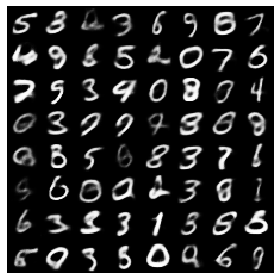

  1%|          | 8/1000 [06:27<13:20:40, 48.43s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.8599999807775021 and for +1: 0.13999999687075615
On batch number 1/590 and on k = 2 we have for  0: 0.9299999792128801 and for +1: 0.06999999843537807
On batch number 101/590 and on k = 1 we have for  0: 0.9299999792128801 and for +1: 0.06999999843537807
On batch number 101/590 and on k = 2 we have for  0: 0.9299999792128801 and for +1: 0.06999999843537807
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.99999

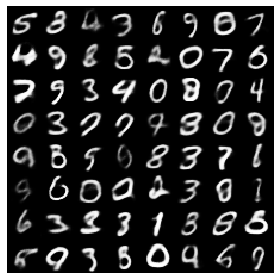

  1%|          | 9/1000 [07:15<13:20:00, 48.44s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 1/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 2

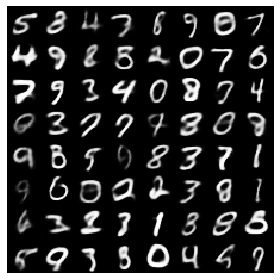

  1%|          | 10/1000 [08:04<13:19:18, 48.44s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9699999783188105 and for +1: 0.029999999329447746
On batch number 1/590 and on k = 2 we have for  0: 0.9599999785423279 and for +1: 0.03999999910593033
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.979999978095293 and for +1: 0.019999999552965164
On batch number 201/590 and on k = 1 we have for  0: 0.9699999783188105 and for +1: 0.029999999329447746
On batch number 201/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9899999778717756 and for +1: 0.009999999776482582
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we h

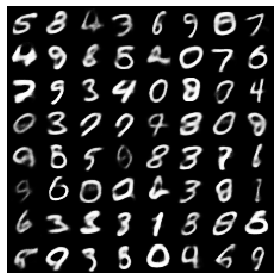

  1%|          | 11/1000 [08:52<13:18:18, 48.43s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 1/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9599999785423279 and for +1: 0.03999999910593033
On batch number 201/590 and on k = 2 we have for  0: 0.9899999778717756 and for +1: 0.009999999776482582
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9899999778717756 and for +1: 0.009999999776482582
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 an

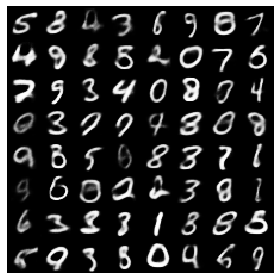

  1%|          | 12/1000 [09:41<13:17:58, 48.46s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 1/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 2

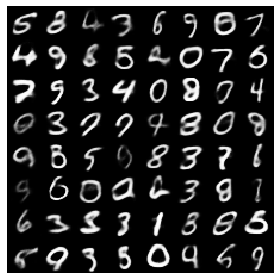

  1%|▏         | 13/1000 [10:29<13:17:09, 48.46s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 1/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 2

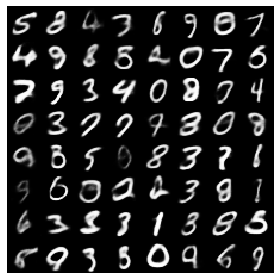

  1%|▏         | 14/1000 [11:18<13:16:11, 48.45s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 1/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 2

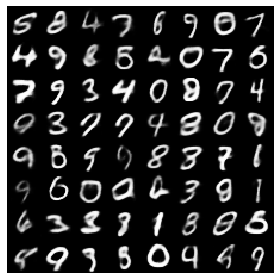

  2%|▏         | 15/1000 [12:06<13:15:13, 48.44s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 1/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 2

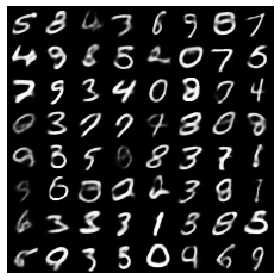

  2%|▏         | 16/1000 [12:54<13:14:19, 48.43s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 1/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 2

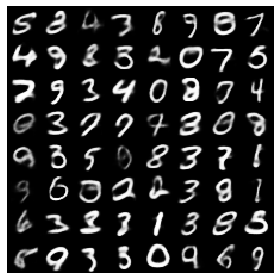

  2%|▏         | 17/1000 [13:43<13:13:28, 48.43s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 1/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 2

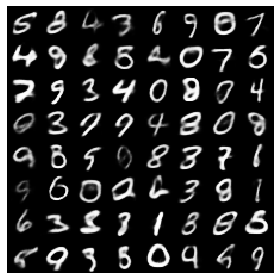

  2%|▏         | 18/1000 [14:31<13:12:48, 48.44s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 1/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 2

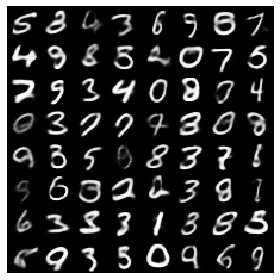

  2%|▏         | 19/1000 [15:20<13:12:05, 48.45s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 1/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 2

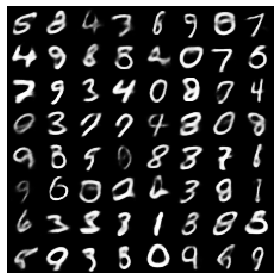

  2%|▏         | 20/1000 [16:08<13:11:14, 48.44s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 1/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 2

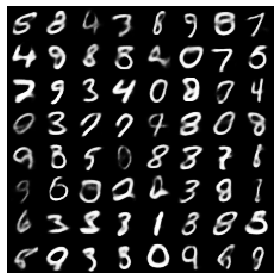

  2%|▏         | 21/1000 [16:57<13:10:22, 48.44s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 1/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 2

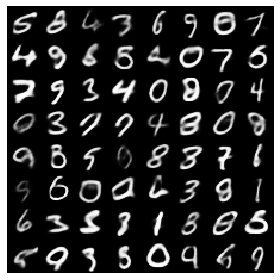

  2%|▏         | 22/1000 [17:45<13:09:24, 48.43s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 1/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 2

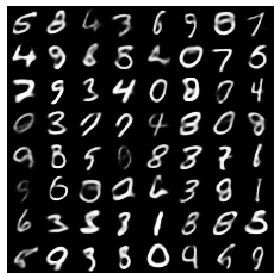

  2%|▏         | 23/1000 [18:33<13:08:40, 48.43s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 1/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 2

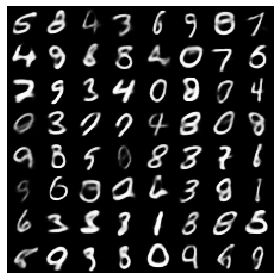

  2%|▏         | 24/1000 [19:22<13:08:00, 48.44s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 1/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 2

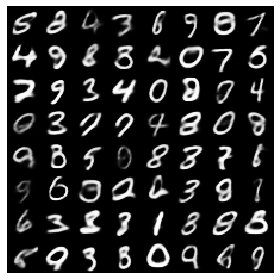

  2%|▎         | 25/1000 [20:10<13:07:10, 48.44s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 1/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 2

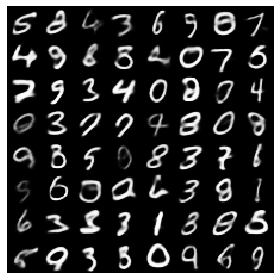

  3%|▎         | 26/1000 [20:59<13:06:15, 48.43s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 1/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 2

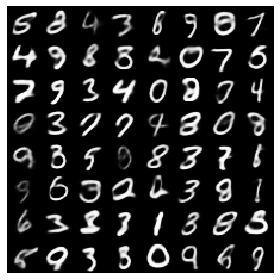

  3%|▎         | 27/1000 [21:47<13:05:21, 48.43s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 1/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 2

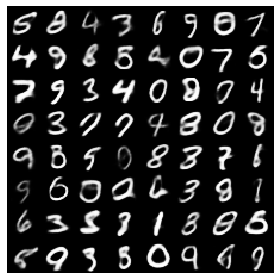

  3%|▎         | 28/1000 [22:36<13:04:21, 48.42s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 1/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 2

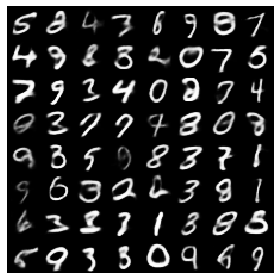

  3%|▎         | 29/1000 [23:24<13:03:28, 48.41s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 1/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 2

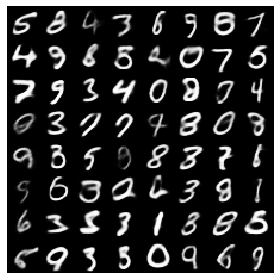

  3%|▎         | 30/1000 [24:12<13:02:40, 48.41s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 1/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 2

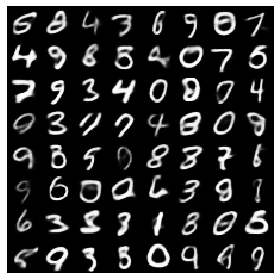

  3%|▎         | 31/1000 [25:01<13:02:01, 48.42s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 1/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 2

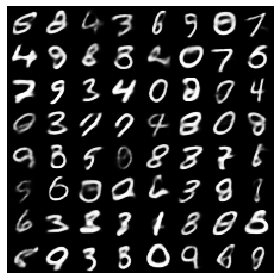

  3%|▎         | 32/1000 [25:49<13:01:05, 48.41s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 1/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 2

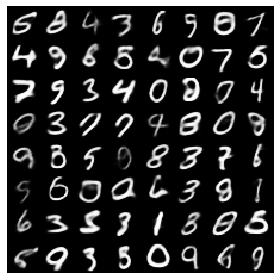

  3%|▎         | 33/1000 [26:38<13:00:26, 48.42s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 1/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 2

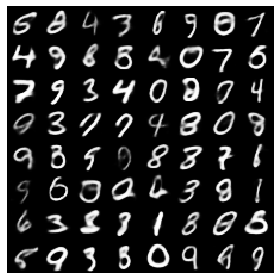

  3%|▎         | 34/1000 [27:26<12:59:33, 48.42s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 1/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 2

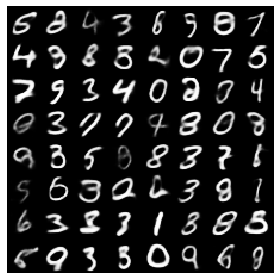

  4%|▎         | 35/1000 [28:15<12:58:39, 48.41s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 1/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 2

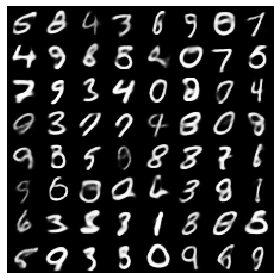

  4%|▎         | 36/1000 [29:03<12:57:52, 48.42s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 1/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9399999789893627 and for +1: 0.05999999865889549
On batch number 501/

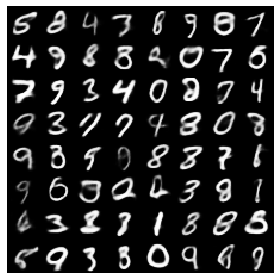

  4%|▎         | 37/1000 [29:51<12:57:09, 48.42s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.8499999810010195 and for +1: 0.14999999664723873
On batch number 1/590 and on k = 2 we have for  0: 0.9299999792128801 and for +1: 0.06999999843537807
On batch number 101/590 and on k = 1 we have for  0: 0.9199999794363976 and for +1: 0.07999999821186066
On batch number 101/590 and on k = 2 we have for  0: 0.9499999787658453 and for +1: 0.04999999888241291
On batch number 201/590 and on k = 1 we have for  0: 0.8999999798834324 and for +1: 0.09999999776482582
On batch number 201/590 and on k = 2 we have for  0: 0.9499999787658453 and for +1: 0.04999999888241291
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and 

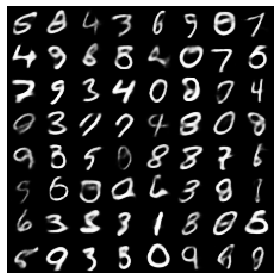

  4%|▍         | 38/1000 [30:40<12:56:27, 48.43s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 1/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.979999978095293 and for +1: 0.019999999552965164
On batch number 501/

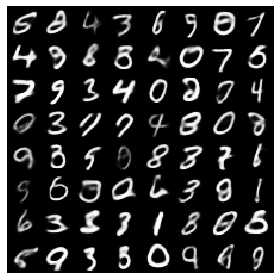

  4%|▍         | 39/1000 [31:28<12:55:34, 48.42s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 1/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 2

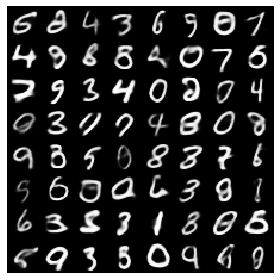

  4%|▍         | 40/1000 [32:17<12:54:42, 48.42s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 1/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 2

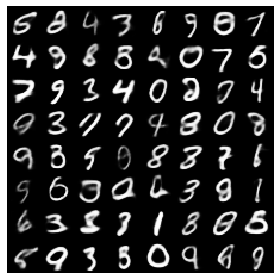

  4%|▍         | 41/1000 [33:05<12:53:44, 48.41s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 1/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 2

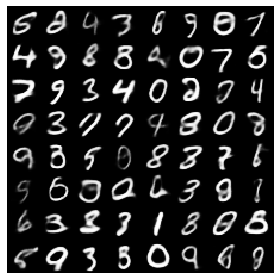

  4%|▍         | 42/1000 [33:53<12:53:01, 48.42s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 1/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 2

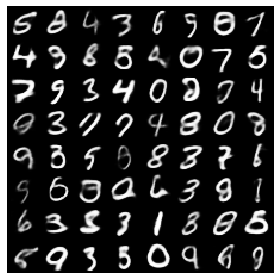

  4%|▍         | 43/1000 [34:42<12:52:10, 48.41s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 1/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.7399999834597111 and for +1: 0.25999999418854713
On batch number 301/590 and on k = 2 we have for  0: 0.6999999843537807 and for +1: 0.29999999329447746
On batch number 401/590 and on k = 1 we have for  0: 0.9599999785423279 and for +1: 0.03999999910593033
On batch number 401/590 and on k = 2 we have for  0: 0.9599999785423279 and for +1: 0.03999999910593033
On batch number 501/590 and on k = 1 we have for  0: 0.93999

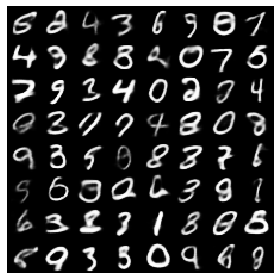

  4%|▍         | 44/1000 [35:30<12:51:23, 48.41s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 1/590 and on k = 2 we have for  0: 0.979999978095293 and for +1: 0.019999999552965164
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/

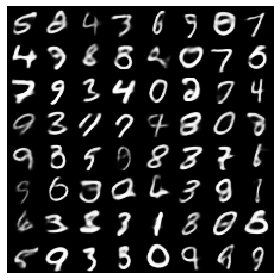

  4%|▍         | 45/1000 [36:19<12:50:32, 48.41s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9899999778717756 and for +1: 0.009999999776482582
On batch number 1/590 and on k = 2 we have for  0: 0.9899999778717756 and for +1: 0.009999999776482582
On batch number 101/590 and on k = 1 we have for  0: 0.9899999778717756 and for +1: 0.009999999776482582
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9899999778717756 and for +1: 0.009999999776482582
On batch number 201/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9

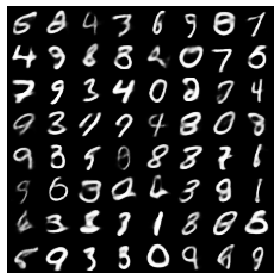

  5%|▍         | 46/1000 [37:07<12:49:46, 48.41s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 1/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 2

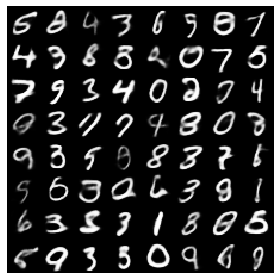

  5%|▍         | 47/1000 [37:56<12:49:14, 48.43s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 1/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 2

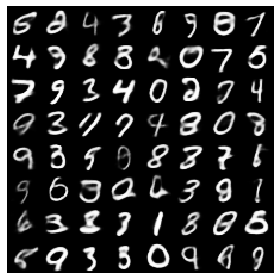

  5%|▍         | 48/1000 [38:44<12:48:22, 48.43s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 1/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 2

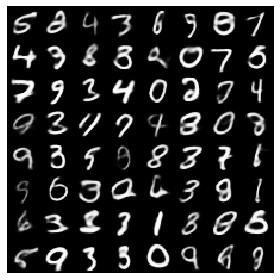

  5%|▍         | 49/1000 [39:32<12:47:25, 48.42s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 1/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 2

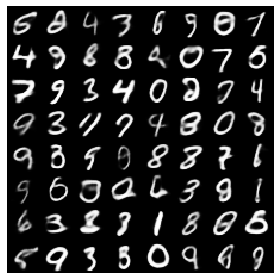

  5%|▌         | 50/1000 [40:21<12:46:35, 48.42s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 1/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 2

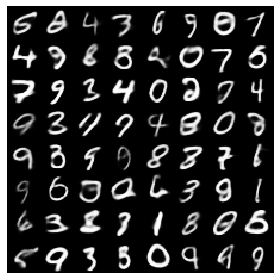

  5%|▌         | 51/1000 [41:09<12:45:46, 48.42s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 1/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 2

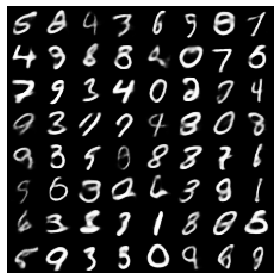

  5%|▌         | 52/1000 [41:58<12:45:07, 48.43s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 1/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 2

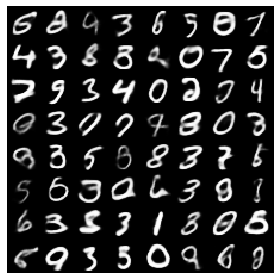

  5%|▌         | 53/1000 [42:46<12:44:17, 48.42s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 1/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 2

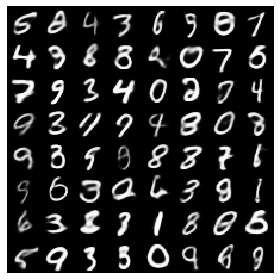

  5%|▌         | 54/1000 [43:35<12:43:34, 48.43s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 1/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 2

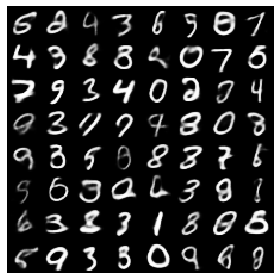

  6%|▌         | 55/1000 [44:23<12:42:42, 48.43s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 1/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 2

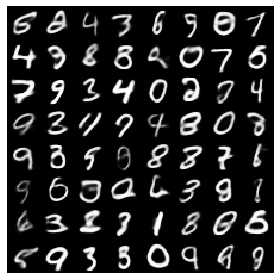

  6%|▌         | 56/1000 [45:11<12:42:05, 48.44s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 1/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 2

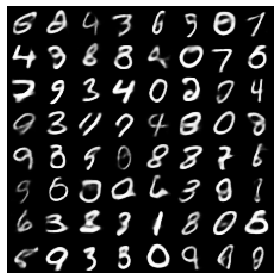

  6%|▌         | 57/1000 [46:00<12:41:07, 48.43s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 1/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 2

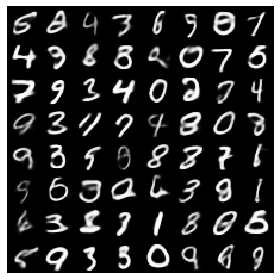

  6%|▌         | 58/1000 [46:48<12:40:26, 48.44s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 1/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 2

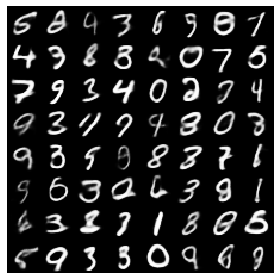

  6%|▌         | 59/1000 [47:37<12:39:32, 48.43s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 1/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 2

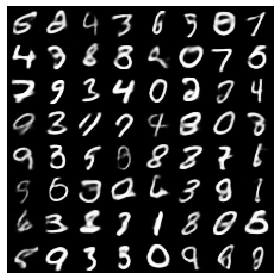

  6%|▌         | 60/1000 [48:25<12:38:43, 48.43s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 1/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 2

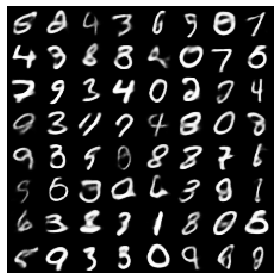

  6%|▌         | 61/1000 [49:14<12:37:48, 48.42s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 1/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 2

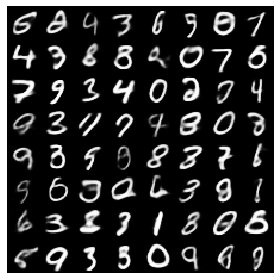

  6%|▌         | 62/1000 [50:02<12:36:55, 48.42s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 1/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 2

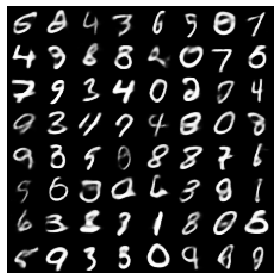

  6%|▋         | 63/1000 [50:50<12:36:07, 48.42s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 1/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 2

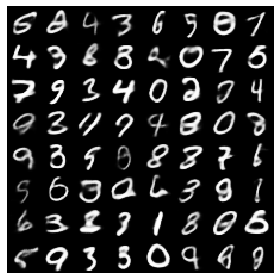

  6%|▋         | 64/1000 [51:39<12:35:17, 48.42s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 1/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 2

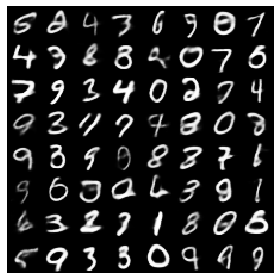

  6%|▋         | 65/1000 [52:27<12:34:27, 48.41s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 1/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 2

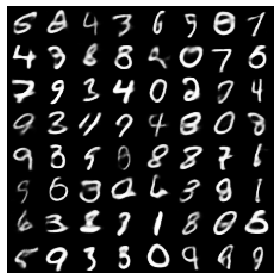

  7%|▋         | 66/1000 [53:16<12:33:53, 48.43s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 1/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 2

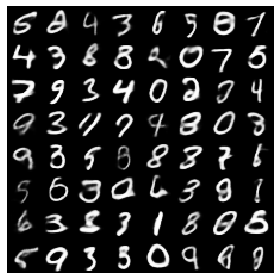

  7%|▋         | 67/1000 [54:04<12:33:15, 48.44s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 1/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 2

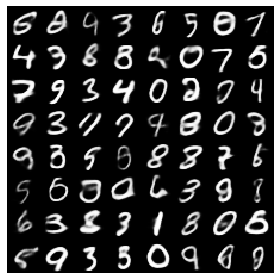

  7%|▋         | 68/1000 [54:53<12:32:18, 48.43s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 1/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 2

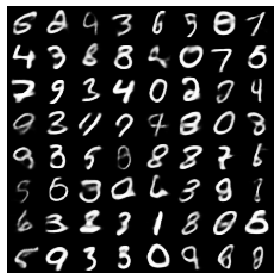

  7%|▋         | 69/1000 [55:41<12:31:19, 48.42s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 1/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 2

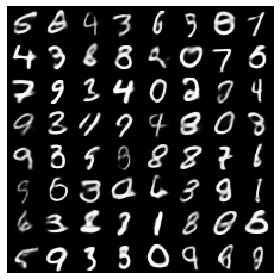

  7%|▋         | 70/1000 [56:29<12:30:33, 48.42s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 1/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 2

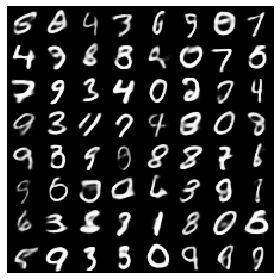

  7%|▋         | 71/1000 [57:18<12:29:43, 48.42s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 1/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 2

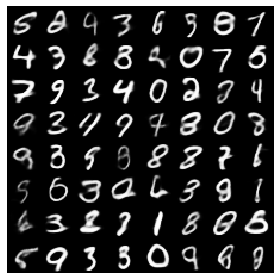

  7%|▋         | 72/1000 [58:06<12:29:04, 48.43s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 1/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 2

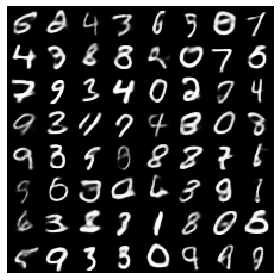

  7%|▋         | 73/1000 [58:55<12:28:06, 48.42s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 1/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 2

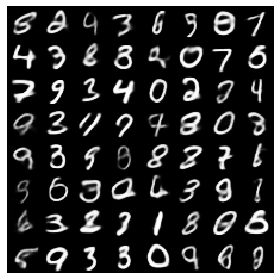

  7%|▋         | 74/1000 [59:43<12:27:12, 48.41s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9499999787658453 and for +1: 0.04999999888241291
On batch number 1/590 and on k = 2 we have for  0: 0.9699999783188105 and for +1: 0.029999999329447746
On batch number 101/590 and on k = 1 we have for  0: 0.9699999783188105 and for +1: 0.029999999329447746
On batch number 101/590 and on k = 2 we have for  0: 0.9899999778717756 and for +1: 0.009999999776482582
On batch number 201/590 and on k = 1 we have for  0: 0.9499999787658453 and for +1: 0.04999999888241291
On batch number 201/590 and on k = 2 we have for  0: 0.9899999778717756 and for +1: 0.009999999776482582
On batch number 301/590 and on k = 1 we have for  0: 0.979999978095293 and for +1: 0.019999999552965164
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9899999778717756 and for +1: 0.0099999997

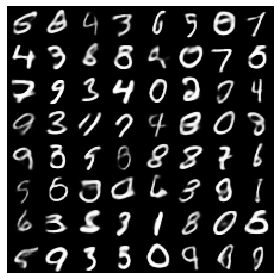

  8%|▊         | 75/1000 [1:00:31<12:26:23, 48.41s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9899999778717756 and for +1: 0.009999999776482582
On batch number 1/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 2 we have for  0: 0.9899999778717756 and for +1: 0.009999999776482582
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9899999778717756 and for +1: 0.009999999776482582
On batch number 401/590 and on k = 2 we have for  0: 0.9899999778717756 and for +1: 0.009999999776482582
On batch number 501/590 and on k = 1 we have for  0: 0.9

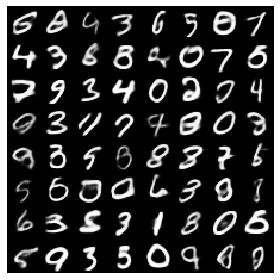

  8%|▊         | 76/1000 [1:01:20<12:25:36, 48.42s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 1/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 2

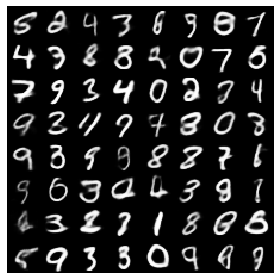

  8%|▊         | 77/1000 [1:02:08<12:24:44, 48.41s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9899999778717756 and for +1: 0.009999999776482582
On batch number 1/590 and on k = 2 we have for  0: 0.9699999783188105 and for +1: 0.029999999329447746
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 2 we have for  0: 0.9899999778717756 and for +1: 0.009999999776482582
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 a

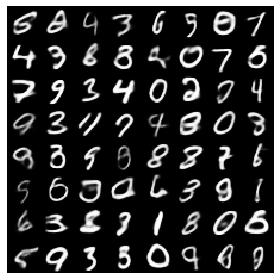

  8%|▊         | 78/1000 [1:02:57<12:24:03, 48.42s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 1/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 2

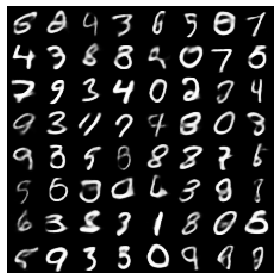

  8%|▊         | 79/1000 [1:03:45<12:23:13, 48.42s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 1/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 2

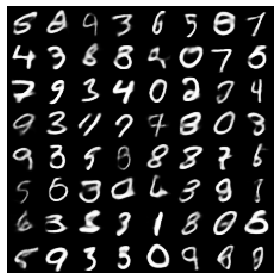

  8%|▊         | 80/1000 [1:04:34<12:22:36, 48.43s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 1/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 2

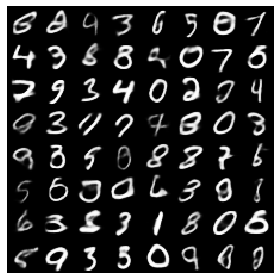

  8%|▊         | 81/1000 [1:05:22<12:21:42, 48.43s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 1/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 2

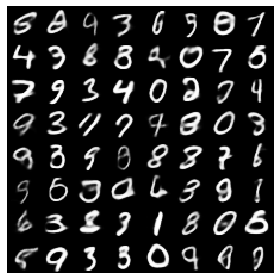

  8%|▊         | 82/1000 [1:06:10<12:20:54, 48.43s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 1/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 2

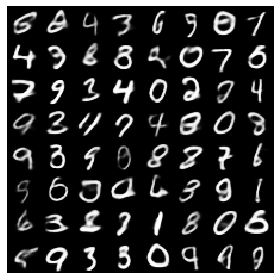

  8%|▊         | 83/1000 [1:06:59<12:20:05, 48.42s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 1/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 2

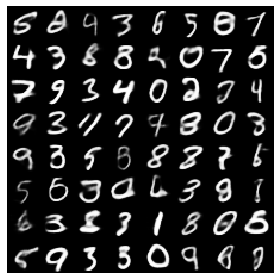

  8%|▊         | 84/1000 [1:07:47<12:19:15, 48.42s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 1/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 2

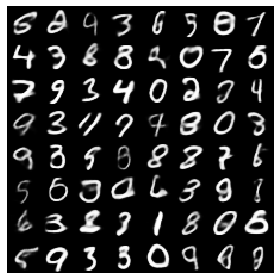

  8%|▊         | 85/1000 [1:08:36<12:18:24, 48.42s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 1/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 2

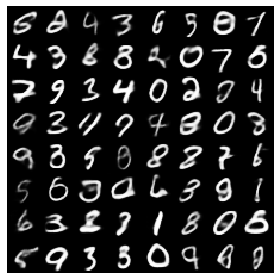

  9%|▊         | 86/1000 [1:09:24<12:17:48, 48.43s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 1/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 2

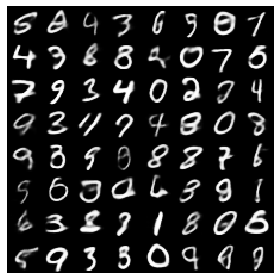

  9%|▊         | 87/1000 [1:10:13<12:17:01, 48.44s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 1/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 2

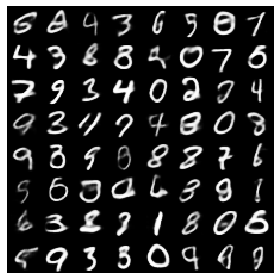

  9%|▉         | 88/1000 [1:11:01<12:16:04, 48.43s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 1/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 2

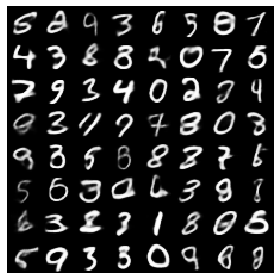

  9%|▉         | 89/1000 [1:11:49<12:15:21, 48.43s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 1/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 101/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/590 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 1 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 501/590 and on k = 2

ValueError: 

In [10]:
print_info_ = 1
torch_log_2 = torch.tensor(np.log(2.), device=args.device, dtype=args.torchType)

best_elbo = -float("inf")
current_elbo_val = -float("inf")

current_tolerance = 0
# with torch.autograd.detect_anomaly():
for ep in tqdm(range(args.num_epoches)): # cycle over epoches
    for b_num, batch_train in enumerate(dataset.next_train_batch()): # cycle over batches
        target.decoder.train()
        plt.close()        

        mu, sigma,h = encoder(batch_train) # sample mu and sigma from encoder
        u = args.std_normal.sample(mu.shape) # sample random tensor for reparametrization trick
        z = mu + sigma * u # reperametrization trick
        sum_log_sigma = torch.sum(torch.log(sigma), 1)
        if ep < args.vanilla_vae_epoches:
            log_p = target.get_logdensity(z=z, x=batch_train)
            log_m = args.std_normal.log_prob(u).sum(1) - sum_log_sigma
            elbo_full = torch.mean(log_p - log_m)
            (-elbo_full).backward()
            optimizer_vanilla.step()
            optimizer_vanilla.zero_grad()
            if b_num == (args.train_batch_size - 1):
                args.train_batch_size = batch_size
                dataset = Dataset(args, device=args.device)
        else:
            target.train()
            p_old = args.std_normal.sample(z.shape)
            cond_vectors = [args.std_normal.sample(p_old.shape) for k in range(args.K)]

            sum_log_alpha = torch.zeros(mu.shape[0], dtype=args.torchType, device=args.device) # for grad log alpha accumulation
            sum_log_jacobian = torch.zeros(mu.shape[0], dtype=args.torchType, device=args.device) # for log_jacobian accumulation
            p = p_old
            if args.learnable_reverse:
                all_directions = torch.tensor([], device=args.device)
            else:
                all_directions = None
            for k in range(args.K):
                # sample alpha - transition probabilities 
                if args.amortize:
#                     pdb.set_trace()
                    z, p, log_jac, current_log_alphas, directions, _ = transitions.make_transition(q_old=z, x=batch_train,
                                                        p_old=p, k=cond_vectors[k], target_distr=target, accept_func= accept_func, h=h)
                else:
                    z, p, log_jac, current_log_alphas, directions, _ = transitions[k].make_transition(q_old=z, x=batch_train,
                                                                        p_old=p, k=cond_vectors[k], target_distr=target, accept_func= accept_func, h=h) # sample a_i -- directions
                if ep  % print_info_ == 0 and b_num % (100 * print_info_) == 0:
                    print('On batch number {}/{} and on k = {} we have for  0: {} and for +1: {}'.format(b_num + 1,
                                                                            dataset.train.shape[0] // args['train_batch_size'],
                                                                               k + 1,
                                                        (directions==0.).to(float).mean(),
                                                                        (directions==1.).to(float).mean()))
                    if args.amortize:
                        print('Stepsize {}'.format(np.exp(transitions.gamma.cpu().detach().item())))
                        print('Autoregression coeff {}'.format(torch.sigmoid(transitions.alpha_logit).cpu().detach().item()))
                if args.learnable_reverse:
                    all_directions = torch.cat([all_directions, directions.view(-1, 1)], dim=1)
                # Accumulate alphas
                sum_log_alpha = sum_log_alpha + current_log_alphas
                sum_log_jacobian = sum_log_jacobian + log_jac  # refresh log jacobian
            ##############################################
            if args.hoffman_idea:
                if args.learnable_reverse:
                    log_r = reverse_kernel(z_fin=z.detach(), h=h, a=all_directions)
                    log_m = args.std_normal.log_prob(u).sum(1) + args.std_normal.log_prob(p_old).sum(1) - sum_log_jacobian - sum_log_sigma + sum_log_alpha
                else:
                    log_r = -args.K * torch_log_2
                    log_m = args.std_normal.log_prob(u).sum(1) + args.std_normal.log_prob(p_old).sum(1) - sum_log_jacobian - sum_log_sigma  + sum_log_alpha
                log_p = target.get_logdensity(z=z, x=batch_train) + args.std_normal.log_prob(p.sum(1))
                elbo_full = log_p + log_r - log_m
#                 pdb.set_trace()
                ### Gradient of the first objective:
                target.eval()
                obj_1 = torch.mean(elbo_full + elbo_full.detach() * sum_log_alpha)
                (-obj_1).backward(retain_graph=True)
                optimizer_inference.step()
                optimizer_inference.zero_grad()
                optimizer.zero_grad() 
                
                ### Gradient of the second objective:
                target.train()
                log_p = target.get_logdensity(z=z.detach(), x=batch_train) + args.std_normal.log_prob(p.detach()).sum(1)
                elbo_full = log_p # - log_m
                obj_2 = torch.mean(elbo_full)
                (-obj_2).backward()
                optimizer.step()
                optimizer_inference.zero_grad()
                optimizer.zero_grad()
            ###########################################################
            else:
                elbo_full, grad_elbo = compute_loss(z_new=z, p_new=p, u=u, p_old=p_old, x=batch_train, sum_log_alpha=sum_log_alpha,
                                                    sum_log_jac=sum_log_jacobian, sum_log_sigma=sum_log_sigma, mu=mu, all_directions=all_directions)
                (-grad_elbo).backward()
                if args.clip_norm:
                    torch.nn.utils.clip_grad_norm_(itertools.chain(*params), args.clip_value)

                if args.separate_params: # if we separate params of inference part and generation part
                    optimizer_inference.step() # we always perform step for inference part
                    if (ep - args.vanilla_vae_epoches) % args.train_only_inference_period > args.train_only_inference_cutoff: # but sometimes for gen
                        optimizer.step()
                    optimizer.zero_grad()
                    optimizer_inference.zero_grad()
                else:
                    optimizer.step()
                    optimizer.zero_grad()
                
    ###### validation ######
    target.decoder.eval()
#             pdb.set_trace()
    current_elbo_val = validate_vae(args=args, encoder=encoder, target=target, transitions=transitions, dataset=dataset)
    if (current_elbo_val != current_elbo_val).sum():
        print('NAN appeared!')
        raise ValueError
    if current_elbo_val > best_elbo:
        current_tolerance = 0
        best_elbo = current_elbo_val
        if not os.path.exists('./models/{}/'.format(args.data)):
            os.makedirs('./models/{}/'.format(args.data))
        torch.save(encoder,
            './models/{}/best_encoder_data_{}_K_{}_N_{}_fixtransition_{}_amortize_{}_learnreverse_{}_vanillaepoches_{}_hoffmanlike_{}_learnaccept_{}.pt'.format(args.data,
                                    args.data, args.K, args.N, args.fix_transition_params, args.amortize, args.learnable_reverse, args.vanilla_vae_epoches,
                                                                                                                args.hoffman_idea, args.learnable_accept))
        torch.save(target.decoder,
            './models/{}/best_decoder_data_{}_K_{}_N_{}_fixtransition_{}_amortize_{}_learnreverse_{}_vanillaepoches_{}_hoffmanlike_{}_learnaccept_{}.pt'.format(args.data,
                                    args.data, args.K, args.N, args.fix_transition_params, args.amortize, args.learnable_reverse, args.vanilla_vae_epoches,
                                                                                                                    args.hoffman_idea, args.learnable_accept))
        torch.save(transitions,
            './models/{}/best_transitions_data_{}_K_{}_N_{}_fixtransition_{}_amortize_{}_learnreverse_{}_vanillaepoches_{}_hoffmanlike_{}_learnaccept_{}.pt'.format(args.data,
                                    args.data, args.K, args.N, args.fix_transition_params, args.amortize, args.learnable_reverse, args.vanilla_vae_epoches,
                                                                                                                    args.hoffman_idea, args.learnable_accept))
        if args.learnable_reverse:
            torch.save(reverse_kernel,
            './models/{}/best_reverse_data_{}_K_{}_N_{}_fixtransition_{}_amortize_{}_learnreverse_{}_vanillaepoches_{}_hoffmanlike_{}_learnaccept_{}.pt'.format(args.data,
                                    args.data, args.K, args.N, args.fix_transition_params, args.amortize, args.learnable_reverse, args.vanilla_vae_epoches,
                                                                                                                    args.hoffman_idea, args.learnable_accept))
        if args.learnable_accept:
            torch.save(accept_func,
            './models/{}/best_accept_data_{}_K_{}_N_{}_fixtransition_{}_amortize_{}_learnreverse_{}_vanillaepoches_{}_hoffmanlike_{}_learnaccept_{}.pt'.format(args.data,
                                    args.data, args.K, args.N, args.fix_transition_params, args.amortize, args.learnable_reverse, args.vanilla_vae_epoches,
                                                                                                                    args.hoffman_idea, args.learnable_accept))

    else:
        current_tolerance += 1
        if current_tolerance >= args.early_stopping_tolerance:
            print("Early stopping on epoch {} (effectively trained for {} epoches)".format(ep,
                                              ep - args.early_stopping_tolerance))
            break
                
    if ep % print_info_ == 0:
        target.decoder.eval()
        print('Current epoch:', (ep + 1), '\t', 'Current ELBO train:', elbo_full.detach().mean().item())
        print('Best elbo validation', best_elbo)
        print('Current elbo validation', current_elbo_val)
        plot_digit_samples(samples=get_samples(target.decoder, random_code), args=args, epoch=ep)

In [ ]:
print(best_elbo)

In [ ]:
elbo_full.mean()

In [ ]:
print(args.learnable_reverse)

## Vanilla VAE

In [ ]:
dataset = Dataset(args, device=args.device)

In [ ]:
if args.data == 'toy_data':
    encoder = Inf_network_simple(kwargs=args).to(args.device)
    target = NN_Gaussian(kwargs=args, model=Gen_network_simple(args.z_dim, args), device=args.device).to(args.device)   
else:
    encoder = Inf_network(kwargs=args).to(args.device)
    target = NN_bernoulli(kwargs=args, model=Gen_network(args.z_dim, args), device=args.device).to(args.device)

params = [encoder.parameters(), target.parameters()]
optimizer = torch.optim.Adam(params=itertools.chain(*params), lr=args.learning_rate)

In [ ]:
print_info_ = 10

# with torch.autograd.detect_anomaly():
for ep in tqdm(range(args.num_epoches)): # cycle over epoches
    for b_num, batch_train in enumerate(dataset.next_train_batch()): # cycle over batches
        plt.close()
        optimizer.zero_grad()

        mu, sigma = encoder(batch_train) # sample mu and sigma from encoder
        u = args.std_normal.sample(mu.shape) # sample random tensor for reparametrization trick
        z = mu + sigma * u # reperametrization trick
        
        mu_dec, sigma_dec = target.decoder(z)
        if args.data == 'toy_data':
            log_numenator = torch.distributions.Normal(loc=mu_dec, scale=sigma_dec).log_prob(batch_train).sum(1) + args.std_normal.log_prob(z).sum(1)
        else:
            log_numenator = torch.distributions.Bernoulli(logits=mu_dec).log_prob(batch_train).sum([1, 2, 3]) + args.std_normal.log_prob(z).sum(1)
        log_denumenator = -torch.sum(torch.log(sigma), 1) + args.std_normal.log_prob(u).sum(1)
        elbo = torch.mean(log_numenator - log_denumenator)
        (-elbo).backward()

        optimizer.step()
        optimizer.zero_grad()
    if ep % print_info_ == 0:
        if args.data == 'toy_data':
            print('Current epoch:', (ep + 1), '\t', 'Current ELBO:', elbo.detach().mean().item())
            print('Mean abs mu0:', torch.mean(torch.abs(mu_dec[:, 0])).cpu().detach().numpy())
            print('Mean sigma', torch.mean(sigma).cpu().detach().numpy())
            print('Max sigma', torch.max(sigma).cpu().detach().numpy())
            print('Min sigma', torch.min(sigma).cpu().detach().numpy())
            plt.scatter(batch_train.cpu().detach().numpy()[:, 0], batch_train.cpu().detach().numpy()[:, 1], label='Data')
            plt.scatter(mu_dec.cpu().detach().numpy()[:, 0], mu_dec.cpu().detach().numpy()[:, 1], label='Reconstructed')
            plt.legend()
            plt.show()
        else:
            plot_digit_samples(samples=get_samples(target.decoder, random_code), args=args, epoch=ep)

In [ ]:
target.decoder.linear1.bias